In [2]:
from PIL import Image
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# # change all files from '.png' to '.jpg'
# dir = 'data/masks'
# for filename in os.listdir(dir):
#     if filename.endswith('.png'):
#         prefix = filename.split('.png')[0]
#         os.rename(dir + '/' + filename, dir + '/' + prefix + '.jpg')

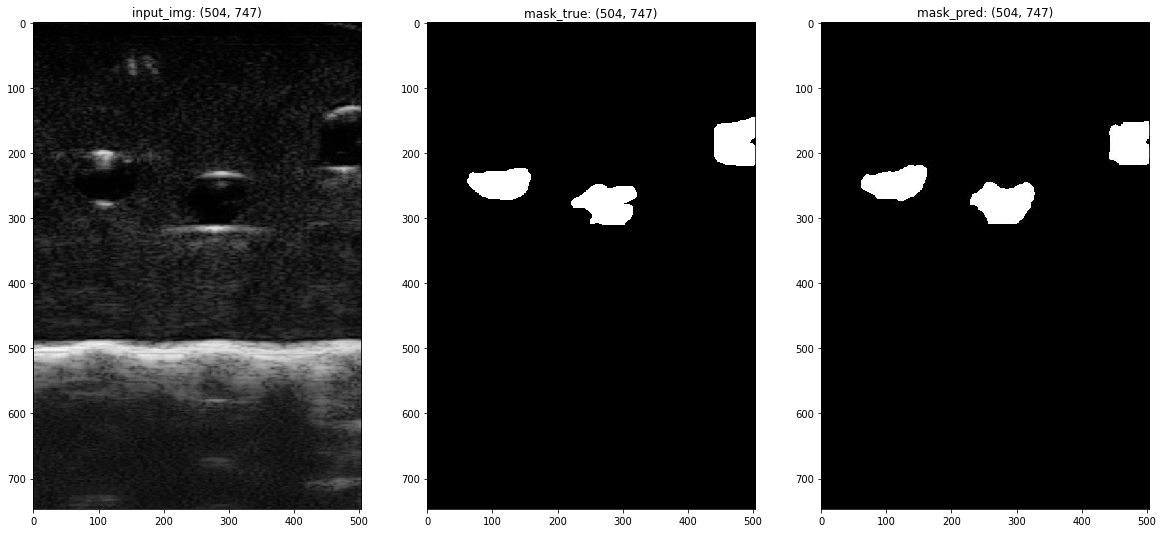

In [3]:
# compare results
input_img = Image.open('data/imgs/9.jpg')
mask_true = Image.open('data/masks/9.jpg')
mask_pred = Image.open('data/output/9_CP20.jpg')

imgs = [input_img, mask_true, mask_pred]
titles = [f'input_img: {input_img.size}', f'mask_true: {mask_true.size}', f'mask_pred: {mask_pred.size}']
plt.figure(figsize=(20,10))
for i, (img, title) in enumerate(zip(imgs, titles)):
    plt.subplot(1, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(title)

In [4]:
import torch
from unet import UNet
from predict import predict_img

In [10]:
# Load Trained Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def load_model(model_file_name):
    net = UNet(n_channels=1, n_classes=1)
    net.to(device=device)
    net.load_state_dict(torch.load(model_file_name, map_location=device))
    return net

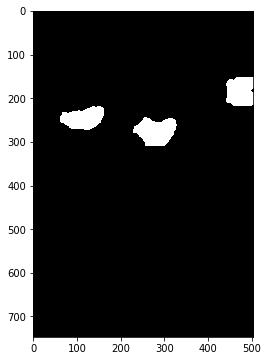

In [11]:
# Predict Single Image
net = load_model('checkpoints/train_1_Feb_5/CP_epoch20.pth')
mask_pred_here = predict_img(net=net, full_img=input_img, scale_factor=1.0, out_threshold=0.5, device=device)
plt.figure(figsize=(8,6))
plt.imshow(mask_pred_here, cmap='gray')

In [22]:
from eval import eval_net
from utils.dataset import BasicDataset
from torch.utils.data import DataLoader
import logging
from tqdm import tqdm

In [28]:
# Decide The Best Saved Model during One Training
"""Given a checkpoints dir storing trained model during a training process, check and find the best model in terms of validation score."""
checkpoints_dir = 'checkpoints/train_1_Feb_5'
dataset = BasicDataset(imgs_dir='data/imgs/', masks_dir='data/masks/', scale=1.0)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=1, pin_memory=True)

best_val_score = 0
best_model_name = None
for model_name in os.listdir(checkpoints_dir):
    if not model_name.endswith('.pth'):
        continue
    net = load_model(os.path.join(checkpoints_dir, model_name))
    val_score = eval_net(net=net, loader=dataloader, device=device, n_val=len(dataset))
    if val_score > best_val_score:
        best_val_score = val_score
        best_model_name = model_name

print(f'best_model_name: {best_model_name} and its validation score: {best_val_score}')

Validation round: 100%|██████████| 20/20 [00:01<00:00, 11.04img/s]best_model_name: CP_epoch15.pth and its validation score: 0.9102348178625107


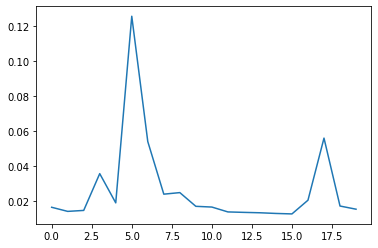

In [11]:
## Train Loss and Validation Score curves
# Extract Loss Data From Saved Model File and Plot the Training Loss Curve and Validation Score Curve
checkpoints_dir = 'checkpoints/train_2'

train_loss_list = []
val_score_list = []
for checkpoint_file in os.listdir(checkpoints_dir):
    if not checkpoint_file.endswith('.pth'):
        continue
    # print(os.path.join(checkpoints_dir, checkpoint_file))
    checkpoint = torch.load(os.path.join(checkpoints_dir, checkpoint_file))
    train_loss_list.extend(checkpoint['loss_list'])
    val_score_list.extend(checkpoint['val_score_list'])

fig = plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(range(0, len(train_loss_list)), train_loss_list)


